In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [13]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model

In [14]:
with open("data/sin/sin_preprocessed.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["X"])
Y = np.array(data["Y"])
X.shape, Y.shape

((9894, 100, 2), (9894, 5))

In [15]:
def build_denoising_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    encoded = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(encoded)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = UpSampling1D(size=2)(x)

    decoded = Conv1D(1, kernel_size=3, padding='same', activation='linear')(x)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [16]:
save_callback = ModelCheckpoint(
    "models/autoencoder/autoencoder.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=0,
    save_weights_only=False,
    save_freq="epoch",
    initial_value_threshold=None,
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, min_lr=0.00001, verbose=1)

In [17]:
autoencoder = build_denoising_autoencoder((X.shape[1], 1))
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 32)           128       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 25, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 25, 32)            3104

In [18]:
history = autoencoder.fit(X[:,:,0], X[:,:,0], epochs=50,
                          batch_size=32, validation_split=0.1,
                          callbacks=[reduce_lr, save_callback])


Epoch 1/50
279/279 [==============================] - 2s 5ms/step - loss: 0.3510 - val_loss: 0.1471 - lr: 0.0010
Epoch 2/50
279/279 [==============================] - 1s 5ms/step - loss: 0.1090 - val_loss: 0.0977 - lr: 0.0010
Epoch 3/50
279/279 [==============================] - 1s 5ms/step - loss: 0.0837 - val_loss: 0.0862 - lr: 0.0010
Epoch 4/50
279/279 [==============================] - 1s 4ms/step - loss: 0.0758 - val_loss: 0.0797 - lr: 0.0010
Epoch 5/50
279/279 [==============================] - 1s 4ms/step - loss: 0.0712 - val_loss: 0.0791 - lr: 0.0010
Epoch 6/50
279/279 [==============================] - 1s 4ms/step - loss: 0.0676 - val_loss: 0.0741 - lr: 0.0010
Epoch 7/50
279/279 [==============================] - 1s 4ms/step - loss: 0.0647 - val_loss: 0.0711 - lr: 0.0010
Epoch 8/50
279/279 [==============================] - 1s 4ms/step - loss: 0.0622 - val_loss: 0.0692 - lr: 0.0010
Epoch 9/50
279/279 [==============================] - 1s 4ms/step - loss: 0.0602 - val_loss: 0.0

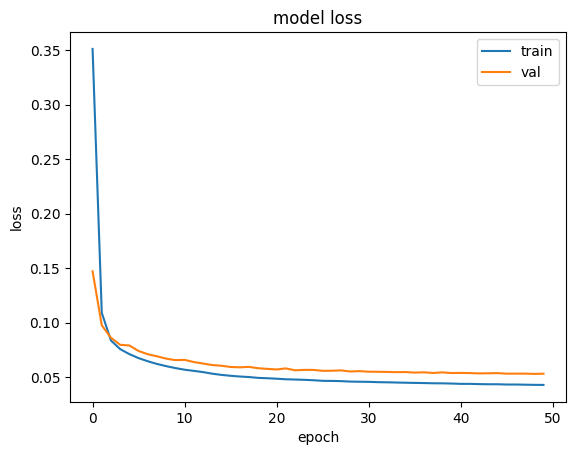

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 53ms/step


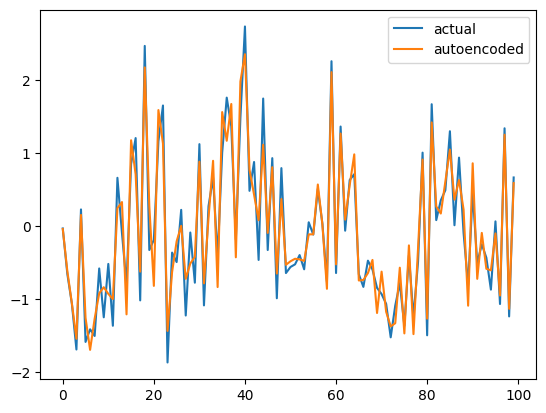

In [20]:
autoencoder = load_model('models/autoencoder/autoencoder.keras')

plt.plot(X[-1,:,0])
plt.plot(autoencoder.predict(X[-1:,:,0])[0])
plt.legend(['actual', 'autoencoded'], loc='upper right')
plt.show()

310/310 [==============================] - 0s 1ms/step


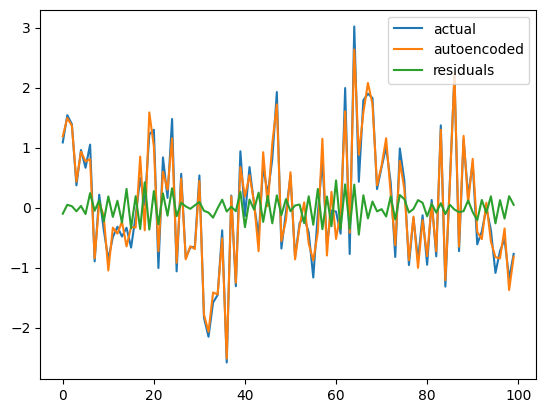

In [21]:
autoencoded_X = autoencoder.predict(X[:,:,0])
residuals_X = X[:,:,0] - autoencoded_X.reshape((-1, 100))
volume = X[:,:,1]

plt.plot(X[0,:,0])
plt.plot(autoencoded_X[0])
plt.plot(residuals_X[0])
plt.legend(['actual', 'autoencoded', 'residuals'], loc='upper right')
plt.show()

In [22]:
autoencoded_data = {"autoencoded_X":autoencoded_X,
                    "residuals_X":residuals_X,
                    "volume":volume,
                    "Y":Y}

with open("data/sin/sin_preprocessed_autoencoded.pickle", "wb") as f:
    pickle.dump(autoencoded_data, f)